In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from tqdm import tqdm

colors_4 = ["#DFDFDF", "#93C354", "#0077BB", "#EE7733"]
colors_2 = ["#0077BB", "#EE7733"]

In [2]:

user_data_path_list = ["../data/study_3a/", "../data/study_3b/"]

dfs = []
for user_data_path in user_data_path_list:
    user_data_list = os.listdir(user_data_path)
    user_data_list.sort()
    user_data_list = [user for user in user_data_list if user != ".DS_Store"]
    print(f"No. of users: {len(user_data_list)}")

    df = pd.DataFrame()
    for user_i, user in enumerate(user_data_list):
        file_list = os.listdir(os.path.join(user_data_path, user))
        file_list.sort()
        file_list = [file for file in file_list if file != ".DS_Store"]

        for sess_i, file_name in enumerate(file_list):
            user_data = pd.read_csv(os.path.join(user_data_path, user, file_name))
            user_data["user_id"] = user_i + 1
            user_data["session_idx"] = sess_i + 1
            df = pd.concat([df, user_data], ignore_index=True)

    # make the user_id, session_idx start as the first two columns
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df = df[cols]

    user_list = df["user_id"].unique()
    n_sess = df["session_idx"].max()
    assert n_sess == 16
    n_block = df["block_idx"].max()
    assert n_block == 3

    dfs.append(df)


No. of users: 12
No. of users: 20


In [3]:
# Extract performance metrics (aggregated metrics e.g., completion time & success rate)
performance_dfs = []

for df in dfs:
    # Integrety check
    performance_df = pd.DataFrame()
    user_list = df["user_id"].unique()

    for user_i in user_list:
        n_sess = df[
            (df["user_id"]==user_i)
        ]["session_idx"].max()
        if n_sess != 16: print(f"User {user_i} has {n_sess} sessions.")
        if len(df[df["user_id"]==user_i]["manual_click"].unique()) < 2:
            print(f"User {user_i} doesn't have data from two click types.")

        for sess_i in range(n_sess):
            n_block = int(df[
                (df["user_id"]==user_i) & \
                (df["session_idx"]==sess_i + 1)
            ]["block_idx"].max())
            if n_block != 3: print(f"User {user_i} has {n_block} blocks in session {sess_i+1}.")
                
            for block_i in range(n_block):
                df_temp = df[
                    (df["user_id"]==user_i) & \
                    (df["session_idx"]==sess_i + 1) & \
                    (df["block_idx"]==block_i + 1)
                ]
                if len(df_temp["small_target"].unique()) != 1:
                    print(f"User {user_i} has inconsistent small_target in block {block_i+1} of session {sess_i+1}.")
                if len(df_temp["method"].unique()) != 1:
                    print(f"User {user_i} has inconsistent inference_type in block {block_i+1} of session {sess_i+1}.")
                if len(df_temp["manual_click"].unique()) != 1:
                    print(f"User {user_i} has inconsistent click_type in block {block_i+1} of session {sess_i+1}.")

                n_trial = int(df_temp["trial_idx"].max())
                if n_trial != 25 and n_trial != 26 : print(f"User {user_i} has {n_trial} trials in block {block_i+1} of session {sess_i+1}.")

                for trial_i in range(n_trial):
                    df_temp = df[
                        (df["user_id"]==user_i) & \
                        (df["session_idx"]==sess_i + 1) & \
                        (df["block_idx"]==block_i + 1) & \
                        (df["trial_idx"]==trial_i + 1)
                    ]

                    # Check if "time_elapsed" only increases except for the first step
                    if not (df_temp["time_elapsed"].diff() >= 0).iloc[1:].all():
                        print(f"User {user_i} has inconsistent time_elapsed in trial {trial_i+1} of block {block_i+1} of session {sess_i+1}.")

                    performance_df = pd.concat([performance_df, pd.DataFrame.from_records([{
                        "user_id": user_i,
                        "session_idx": sess_i+1,
                        "block_idx": block_i+1,
                        "trial_idx": trial_i+1,
                        "small_target": df_temp["small_target"].to_numpy()[-1],
                        "manual_click": df_temp["manual_click"].to_numpy()[-1],
                        "method": df_temp["method"].to_numpy()[-1],
                        "target_pos_x": df_temp["target_pos_x"].to_numpy()[0].round(3),
                        "target_pos_y": df_temp["target_pos_y"].to_numpy()[0].round(3),
                        "target_pos_z": df_temp["target_pos_z"].to_numpy()[0].round(3),
                        "time_elapsed": df_temp["time_elapsed"].to_numpy()[-1],
                        "success": df_temp["success"].to_numpy()[-1],
                        "selection": (df_temp["selection"] == 1).sum(),
                        "error": (df_temp["selection"] == 1).sum() > 1,
                        "start_pos_x": df_temp["position_x"].to_numpy()[0],
                        "start_pos_y": df_temp["position_y"].to_numpy()[0],
                        "start_pos_z": df_temp["position_z"].to_numpy()[0],
                        "end_pos_x": df_temp["position_x"].to_numpy()[-1],
                        "end_pos_y": df_temp["position_y"].to_numpy()[-1],
                        "end_pos_z": df_temp["position_z"].to_numpy()[-1],
                        "start_dir_x": df_temp["direction_x"].to_numpy()[0],
                        "start_dir_y": df_temp["direction_y"].to_numpy()[0],
                        "start_dir_z": df_temp["direction_z"].to_numpy()[0],
                        "end_dir_x": df_temp["direction_x"].to_numpy()[-1],
                        "end_dir_y": df_temp["direction_y"].to_numpy()[-1],
                        "end_dir_z": df_temp["direction_z"].to_numpy()[-1],
                        "eye_height": df_temp["eye_height"].to_numpy()[0],
                    }])], axis=0)
                    
    # Reset index of performance_df
    performance_df = performance_df.reset_index(drop=True)
    performance_dfs.append(performance_df)

In [4]:
# Filter outliers
new_performance_dfs = []

for performance_df in performance_dfs:
  # Outlier detection in completion time (within each manual_click, grid, method condition)
  for manual_click in performance_df["manual_click"].unique():
    for method in performance_df["method"].unique():
      performance_df_temp = performance_df[
        (performance_df["manual_click"] == manual_click) & \
        (performance_df["method"] == method)
      ]
      time_z_scores = stats.zscore(performance_df_temp["time_elapsed"])
      abs_time_z_scores = np.abs(time_z_scores)
      time_filtered_entries = (abs_time_z_scores < 3)

      # make a mark at performance_df where the performance_df_temp[abs_time_z_scores >= 3] is
      performance_df.loc[performance_df_temp[abs_time_z_scores >= 3].index, "outlier"] = True
      performance_df.loc[performance_df_temp[abs_time_z_scores < 3].index, "outlier"] = False
        
  # Print total outlier count & percentage
  print(f"Total outlier count: {performance_df[performance_df['outlier'] == True].shape[0]} ({performance_df[performance_df['outlier'] == True].shape[0] / performance_df.shape[0] * 100:.2f} %)")
  
  # Update performance_df where the outlier is removed
  new_performance_dfs.append(performance_df[performance_df["outlier"] == False])

old_performance_dfs = performance_dfs
performance_dfs = new_performance_dfs


Total outlier count: 173 (1.16 %)
Total outlier count: 410 (1.71 %)




	Study 3A


                            OLS Regression Results                            
Dep. Variable:           time_elapsed   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.1451
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.865
Time:                        14:29:53   Log-Likelihood:                 25.413
No. Observations:                  36   AIC:                            -44.83
Df Residuals:                      33   BIC:                            -40.08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------


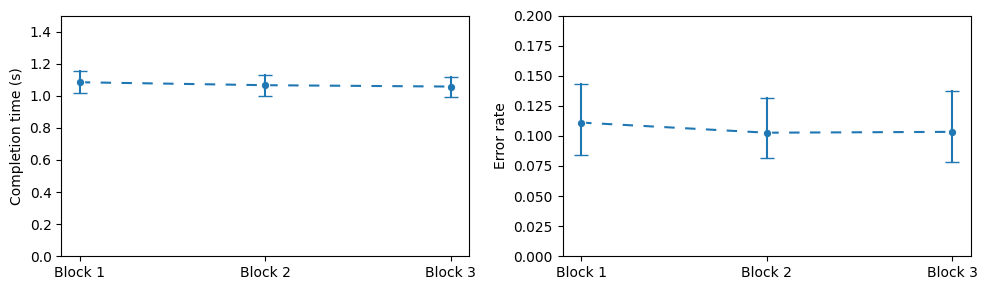



	Study 3B


                            OLS Regression Results                            
Dep. Variable:           time_elapsed   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.4732
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.625
Time:                        14:29:53   Log-Likelihood:                 40.761
No. Observations:                  60   AIC:                            -75.52
Df Residuals:                      57   BIC:                            -69.24
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------


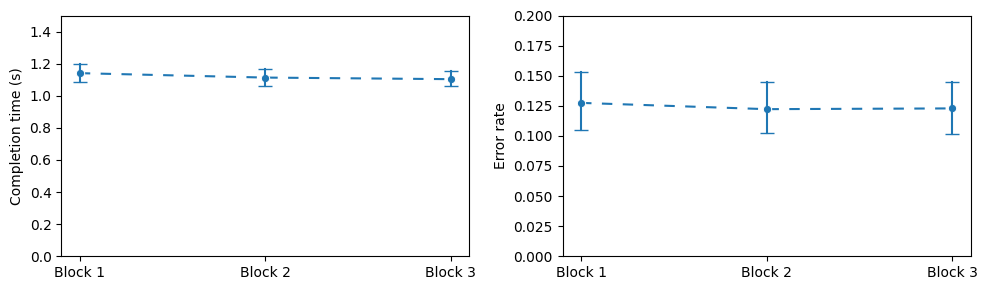

In [5]:
# Investigate learning effects (significance test by Helmert coding)
from statsmodels.formula.api import ols
from patsy.contrasts import ContrastMatrix

group_label = "block_idx"
cond_label = "time_elapsed"

class F_Helmert(object):
    def _name_levels(self, prefix, levels):
        return ["[%s%s]" % (prefix, level) for level in levels]
    
    def _forward_helmert_contrast(self, levels):
        n = len(levels)
        contr = np.zeros((n, n - 1))
        contr[:-1][np.diag_indices(n - 1)] = np.arange(n-1, 0, -1)
        contr[1:][np.tril_indices(n - 1)] = -1
        return contr
   
    def code_with_intercept(self, levels):
        contrast = np.column_stack((np.ones(len(levels)), self._forward_helmert_contrast(levels)))
        return ContrastMatrix(contrast, self._name_levels("FH.", levels))

    def code_without_intercept(self, levels):
        contrast = self._forward_helmert_contrast(levels)
        return ContrastMatrix(contrast, self._name_levels("FH.", levels[:-1]))

for study, performance_df in zip(["Study 3A", "Study 3B"], performance_dfs):
    
    print("\n")
    print("="*20)
    print(f"\t{study}")
    print("="*20)
    print("\n")
    
    performance_df_block = performance_df.groupby(["user_id", "block_idx"]).mean().reset_index()
    performance_df_assist_infer = performance_df.groupby(["user_id", "manual_click", "method"]).mean().reset_index()
    
    mod = ols(f"{cond_label} ~ C({group_label}, F_Helmert)", data=performance_df_block)
    res = mod.fit()
    print(res.summary())

    # Plot the learning effect
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))

    sns.lineplot(
        x="block_idx",
        y="time_elapsed",
        data=performance_df_block,
        ax=ax[0],
        marker="o",
        linestyle=(0, (5, 5)),
        errorbar=("ci", 95),
        err_style="bars",
        err_kws={"capsize": 5},
    )
    ax[0].set_ylabel("Completion time (s)")
    ax[0].set_ylim(0, 1.5)

    sns.lineplot(
        x="block_idx",
        y="error",
        data=performance_df_block,
        ax=ax[1],
        marker="o",
        linestyle=(0, (5, 5)),
        errorbar=("ci", 95),
        err_style="bars",
        err_kws={"capsize": 5},
    )
    ax[1].set_ylabel("Error rate")
    ax[1].set_ylim(0, 0.2)

    for ax_i in [0, 1]:
        ax[ax_i].set_xlabel("")
        ax[ax_i].set_xticks(np.arange(1, 4))
        ax[ax_i].set_xticklabels(["Block 1", "Block 2", "Block 3"])
    plt.tight_layout()
    plt.show()
        

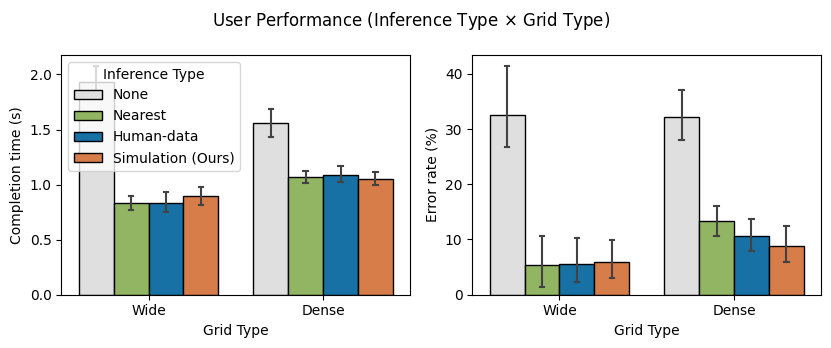

In [6]:
# Figure 10: Aggregate two performance_df in one plot

performance_dfs[0]["dense_grid"] = 0 # Wide grid (Study 3A)
performance_dfs[1]["dense_grid"] = 1 # Dense grid (Study 3B)
performance_df = pd.concat(performance_dfs, ignore_index=True)

# Plot the user performance (visual suggestion condition)
new_df_method = performance_df[performance_df["manual_click"] == 1].groupby(["user_id", "method", "dense_grid"]).mean().reset_index()
new_df_method["error"] *= 100
new_df_method["error_rate"] = \
    (new_df_method["selection"] - new_df_method["success"]) / \
    new_df_method["selection"] * 100

fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5))
sns.barplot(x='dense_grid', y='time_elapsed', hue="method", data=new_df_method, ax=ax[0], palette=colors_4,
            errorbar=('ci', 95), capsize=0.1, edgecolor="black", err_kws={'linewidth': 1.5})
sns.barplot(x='dense_grid', y='error_rate', hue="method", data=new_df_method, ax=ax[1], palette=colors_4,
            errorbar=('ci', 95), capsize=0.1, edgecolor="black", err_kws={'linewidth': 1.5})
fig.suptitle(r"User Performance (Inference Type $\times$ Grid Type)")
ax[0].set_xlabel("Grid Type")
ax[0].set_ylabel("Completion time (s)")
ax[0].set_xticklabels(["Wide", "Dense"])
ax[1].set_xlabel("Grid Type")
ax[1].set_ylabel("Error rate (%)")
ax[1].set_xticklabels(["Wide", "Dense"])

legend = ax[0].legend()
labels = ['None', 'Nearest', 'Human-data', 'Simulation (Ours)']
# Update the labels in the existing legend
for t, l in zip(legend.texts, labels):
    t.set_text(l)
# Optionally, you can also change the title
legend.set_title("Inference Type")
ax[1].legend().remove()

plt.tight_layout()
plt.savefig(os.path.join("../results/plots/", "study3_performance_grid.pdf"), dpi=300)
plt.show()

In [7]:
# RM ANOVA
import pingouin as pg

for study, performance_df in zip(["Study 3A", "Study 3B"], performance_dfs):
    
  print("\n")
  print("="*20)
  print(f"\t{study}")
  print("="*20)
  print("\n")

  agg_performance_df = performance_df.groupby(['user_id', 'method', 'manual_click', 'small_target']).mean().reset_index()
  agg_performance_df["error_rate"] = \
      (agg_performance_df["selection"] - agg_performance_df["success"]) / \
      agg_performance_df["selection"] * 100
  
  # Manual click condition
  print("[ RM-ANOVA for error rate ]")
  res = pg.rm_anova(dv="error_rate", within=['method', 'small_target'], subject="user_id", data=agg_performance_df[agg_performance_df["manual_click"]==1])
  print(res)
  posthocs = pg.pairwise_tests(dv="error_rate", within=['small_target', 'method'], padjust='bonf', subject="user_id", data=agg_performance_df[agg_performance_df["manual_click"]==1])
  pg.print_table(posthocs)

  print("[ RM-ANOVA for completion time ]")
  res = pg.rm_anova(dv="time_elapsed", within=['method', 'small_target'], subject="user_id", data=agg_performance_df[agg_performance_df["manual_click"]==1])
  print(res)
  posthocs = pg.pairwise_tests(dv="time_elapsed", within=['small_target', 'method'], padjust='bonf', subject="user_id", data=agg_performance_df[agg_performance_df["manual_click"]==1])
  pg.print_table(posthocs)



	Study 3A


[ RM-ANOVA for error rate ]
                  Source            SS  ddof1  ddof2           MS           F  \
0                 method  12231.943925      3     33  4077.314642  132.935521   
1           small_target    250.700867      1     11   250.700867   89.666996   
2  method * small_target    795.491421      3     33   265.163807   20.954602   

          p-unc     p-GG-corr       ng2       eps  
0  1.689817e-18  3.129281e-09  0.616474  0.438324  
1  1.271379e-06  1.271379e-06  0.031894  1.000000  
2  8.786200e-08  7.492177e-05  0.094641  0.503710  

POST HOC TESTS

Contrast               small_target      A    B  Paired    Parametric         T     dof  alternative      p-unc    p-corr  p-adjust          BF10    hedges
---------------------  --------------  ---  ---  --------  ------------  ------  ------  -------------  -------  --------  ----------  ----------  --------
small_target           -                 0    1  True      True          -9.469  11.000  two-sid

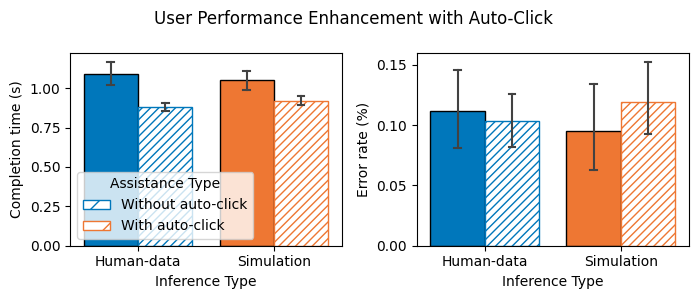

In [8]:
# Figure 11: User performance enhancement with Auto-click

performance_df = performance_dfs[1]
labels = ["Without auto-click", "With auto-click"]

new_df_method_manual = performance_df[(performance_df["method"] == 3) | (performance_df["method"] == 4)].groupby(
    ["user_id", "method", "manual_click"]).mean().reset_index()
new_df_method_manual["error_rate"] = \
    (new_df_method_manual["selection"] - new_df_method_manual["success"]) / \
    new_df_method_manual["selection"] * 100

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=100)
sns.barplot(x='method', y='time_elapsed', hue="manual_click", data=new_df_method_manual, ax=ax[0], palette=colors_4[2:4],
            errorbar=('ci', 95), capsize=0.1, edgecolor="black", errwidth=1.5, order=[3, 4], hue_order=[1, 0])
sns.barplot(x='method', y='error', hue="manual_click", data=new_df_method_manual, ax=ax[1], palette=colors_4[2:4],
            errorbar=('ci', 95), capsize=0.1, edgecolor="black", errwidth=1.5, order=[3, 4], hue_order=[1, 0])
fig.suptitle(r"User Performance Enhancement with Auto-Click")
ax[0].set_xlabel("Inference Type")
ax[0].set_ylabel("Completion time (s)")
ax[0].set_xticklabels(['Human-data', 'Simulation'])
ax[1].set_xlabel("Inference Type")
ax[1].set_ylabel("Error rate (%)")
ax[1].set_xticklabels(['Human-data', 'Simulation'])

for j in range(2):
    for i, thisbar in enumerate(ax[j].patches):
        pattern = ['/', '////', '/', '////'][i // 2]
        if i // 2 == 0:
            thisbar.set_facecolor(colors_4[2:4][i % 2])
        else:
            thisbar.set_facecolor("#ffffff")
            thisbar.set_edgecolor(colors_4[2:4][i % 2])
            thisbar.set_hatch(pattern)

legend = ax[0].legend()
# Update the labels in the existing legend
for t, l in zip(legend.texts, labels):
    t.set_text(l)
legend.set_title("Assistance Type")
ax[1].legend().remove()
plt.tight_layout()
plt.savefig(os.path.join("../results/plots/", "study3_compare.pdf"), dpi=300)
plt.show()

In [9]:
# Comparison between manual and auto clicks (Study 3B)

agg_performance_df = performance_dfs[1].groupby(['user_id', 'method', 'manual_click', 'small_target']).mean().reset_index()
agg_performance_df["error_rate"] = \
    (agg_performance_df["selection"] - agg_performance_df["success"]) / \
    agg_performance_df["selection"] * 100

print("\n[Manual vs. Auto-click] RM-ANOVA for error rate")
res = pg.rm_anova(dv="error_rate", within=['method', 'manual_click'], subject="user_id", data=agg_performance_df)
print(res)
posthocs = pg.pairwise_tests(dv="error_rate", within=['method', 'manual_click'], padjust='bonf', subject="user_id", data=agg_performance_df)
pg.print_table(posthocs)

print("\n[Manual vs. Auto-click] RM-ANOVA for completion time")
res = pg.rm_anova(dv="time_elapsed", within=['method', 'manual_click'], subject="user_id", data=agg_performance_df)
print(res)
posthocs = pg.pairwise_tests(dv="time_elapsed", within=['method', 'manual_click'], padjust='bonf', subject="user_id", data=agg_performance_df)
pg.print_table(posthocs)


[Manual vs. Auto-click] RM-ANOVA for error rate
                  Source           SS  ddof1  ddof2           MS           F  \
0                 method  1114.962915      3     57   371.654305   23.168812   
1           manual_click  3161.251598      1     19  3161.251598   41.691220   
2  method * manual_click  6785.804009      3     57  2261.934670  169.137227   

          p-unc     p-GG-corr       ng2       eps  
0  6.217611e-10  1.022596e-07  0.152597  0.718698  
1  3.450266e-06  3.450266e-06  0.337998  1.000000  
2  2.427618e-28  5.965250e-23  0.522893  0.793256  

POST HOC TESTS

Contrast               method      A    B  Paired    Parametric          T     dof  alternative      p-unc    p-corr  p-adjust             BF10    hedges
---------------------  --------  ---  ---  --------  ------------  -------  ------  -------------  -------  --------  ----------  -------------  --------
method                 -           0    1  True      True            8.783  19.000  two-sided    